**АНАЛИЗ ПРИЧИН УБЫТКОВ ПРИЛОЖЕНИЯ Procrastinate Pro+**

**Цель**
- выделить причины неэффективности привлечения пользователей
- дать рекомендации для отдела маркетинга

**Этапы**
1. загрузка данных и при необходимости их предварительная обработка
2. функции для расчета и анализа LTV, ROI, удержания и конверсии
3. исследовательский анализ данных, включающий:
-  создание пользовательских профилей
-  анализ характеристик платящих пользователей (страна, девайс, канал)
4. маркетинг:
- расчет общей суммы рекламных компаний в целом и по рекламным каналам, визуализация динамики во времени
- расчет общего САС и отдельно для каждого источника трафика
5. оценка окупаемости рекламы:
- общая окупаемость рекламы -  LTV, ROI, графики динамики LTV, CAC и ROI
- окупаемость рекламы в зависимости от страны, источника трафика
- графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам
6. Выводы

**Источник информации**: 
данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными о посещениях
- выгрузка покупок за этот период
- рекламные расходы

# Загрузка данных 

In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import os

Прочитаем данные в датафреймы с учетом директории, в которой лежат csv файлы

In [2]:
def read_file(file_name):
    path1 = os.path.join('/datasets', file_name)
    path2 = os.path.join(file_name)
    if os.path.exists(path1):
        df = pd.read_csv(path1)
        return df
    elif os.path.exists(path2):
        df = pd.read_csv(path2)
        return df
    else:
        print('File is not found')

In [3]:
visits = read_file('visits_info_short.csv')
orders = read_file('orders_info_short.csv')
costs = read_file('costs_info_short.csv')

Проверим, имеются ли в данных дубликаты, пропущенные значения и соответствуют ли типы данных их значениям

In [4]:
df_lst = [visits, orders, costs]
for df in df_lst:
    print(df.dtypes)
    print(df.isna().sum())
    print(df.duplicated().sum())
    print('*'*100)

User Id           int64
Region           object
Device           object
Channel          object
Session Start    object
Session End      object
dtype: object
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
0
****************************************************************************************************
User Id       int64
Event Dt     object
Revenue     float64
dtype: object
User Id     0
Event Dt    0
Revenue     0
dtype: int64
0
****************************************************************************************************
dt          object
Channel     object
costs      float64
dtype: object
dt         0
Channel    0
costs      0
dtype: int64
0
****************************************************************************************************


Для начала откорректируем стиль названия столбцов

In [5]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

Изменим тип данных с object на datetime для дат

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

**Вывод**
- в данных отсутствуют дубликаты и пропущенные значения
- написание названий столбцов приведено к общему стилю
- столбцы, хранящие даты, приведены к datetime типу

# Функции для расчета и анализа LTV, ROI, удержания и конверсии

Опеределим функции для расчета основных метрик юнит-экономики

In [7]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [8]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [9]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [10]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [11]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [12]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [13]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

# Исследовательский анализ данных

## Профиль пользователя

Функция для получения профиля пользователя по его характеристикам при дате первого посещения, включающая расчет acquision cost (цены привлечения пользователя) в соответствии с данными costs и его категоризацию плательщик/неплательщик в соответствии с данными orders

In [14]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [15]:
profiles = get_profiles(visits, orders, costs)

In [16]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


## Минимальная и максимальная даты привлечения пользователей

In [17]:
profiles['dt'].agg(['min', 'max'])

min    2019-05-01
max    2019-10-27
Name: dt, dtype: object

## Платящие пользователи по регионам

Создадим функцию, считающую процент платящих пользователей в зависимости от признака (страны, девайса, канала рекламы)

In [18]:
def get_percent_of_paying_customers_by(column):
    df = profiles.groupby(column).agg({'user_id':'count', 'payer':['sum', 'mean']})
    df.columns = ['total_clients', 'paying_clients', 'percent_paying_clients']
    df = df.sort_values(by = 'total_clients', ascending = False).style.format({'paying_clients': '{:.0f}',
                                                                       'percent_paying_clients': '{:.2%}'})
    display(df)


In [19]:
get_percent_of_paying_customers_by('region')

,total_clients,paying_clients,percent_paying_clients
region,,,
United States,100002,6902,6.90%
UK,17575,700,3.98%
France,17450,663,3.80%
Germany,14981,616,4.11%


## Платящие пользователи по девайсам 

In [20]:
get_percent_of_paying_customers_by('device')

,total_clients,paying_clients,percent_paying_clients
device,,,
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%
Mac,30042,1912,6.36%


## Платящие пользователи по каналам привлечения

In [21]:
get_percent_of_paying_customers_by('channel')

,total_clients,paying_clients,percent_paying_clients
channel,,,
organic,56439,1160,2.06%
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
OppleCreativeMedia,8605,233,2.71%
LeapBob,8553,262,3.06%
WahooNetBanner,8553,453,5.30%
RocketSuperAds,4448,352,7.91%
MediaTornado,4364,156,3.57%
YRabbit,4312,165,3.83%


Посмотрим распределение девайсов по странам

In [22]:
profiles.groupby(['region', 'device'])['user_id'].nunique().reset_index()

,region,device,user_id
0,France,Android,5252
1,France,Mac,1838
2,France,PC,6940
3,France,iPhone,3420
4,Germany,Android,4440
5,Germany,Mac,1584
6,Germany,PC,5945
7,Germany,iPhone,3012
8,UK,Android,5141
9,UK,Mac,1778


**Вывод**:
- мы создали таблицу с профилями пользователей, включающую такие атрибуты как данные о дате первого визита (дата, месяц), id, характеристики клиента при первом визите (страна, девайс, рекламный канал), а также стоимость привлечения клиента
- пользователи привлекались с 1 мая по 27 октября 2019 года
- большинство клиентов используют мобильные устройства, около трети всех клиентов являются обладателями IPhone
- больше всего платящих клиентов используют Mac (на втором месте - IPhone) - сказываются плюсы Apple Store
- наибольшее количество клиентов из США, что неудивительно сопоставляя численность населения анализируемых стран. Самый высокий процент платящих клиентов также из США - скорее всего это обусловлено тем, они в своем большинстве используют IPhone, в то времы как юзеры из других стран - PC. Меньше всего клиентов - в Германии, но при этом меньше всего платящих посетителей проживает во Франции
- большинство пользователей - органики, пришедшие в приложение не по рекламным каналам, однако процент плательщиков среди них самый низкий (количество не всегда означает качество). Наибольшее количество платящих пользователей пришло по FaceBoom и AdNonSense

Скорее всего платные услуги нашего приложения лучше всего работают (или лучше всего адаптированы) на яблоках - IPhone и Mac. Страна клиента не играет решающей роли в его стремлении покупать платные услуги, а лишь обуславливает популярность того или иного девайса. Стоит обратить внимание на функционал платных услуг приложения для PC - является ли он аналогичным как для IPhone. 
Реклама на FaceBoom и AdNonSense либо таргетирует заведомо более платежеспособных клиентов, либо хорошо рекламирует платные услуги приложения и вызывает интерес у пользователей к их покупкам

# Маркетинг

## Расчет общей суммы рекламных компаний в целом и по рекламным каналам, визуализация динамики во времени

In [23]:
int(costs['costs'].sum())

105497

Всего на рекламу было потрачено более 100 тыс.чего-то

Распределение денежных средств по рекламным каналам

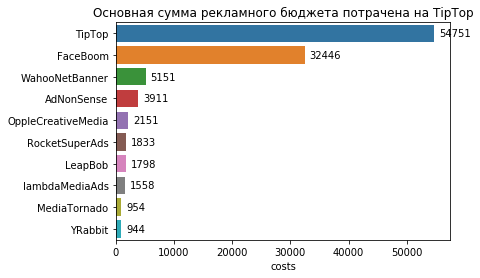

In [24]:
plot = sns.barplot(data = costs.groupby('channel')['costs'].sum().reset_index()
                   .sort_values(by = 'costs', ascending = False), x = 'costs', y = 'channel')
for p in plot.patches:
    plot.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
    xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.title('Основная сумма рекламного бюджета потрачена на TipTop')
plt.ylabel('')
plt.show()

Динамика оплаты рекламных каналов

In [25]:
def draw_graph(index, values, aggfunc, columns = None):
    costs.pivot_table(index = index, columns = columns, values = values, aggfunc = aggfunc).plot(grid = True, figsize = (15,8))

Text(0.5, 0, 'Дата')

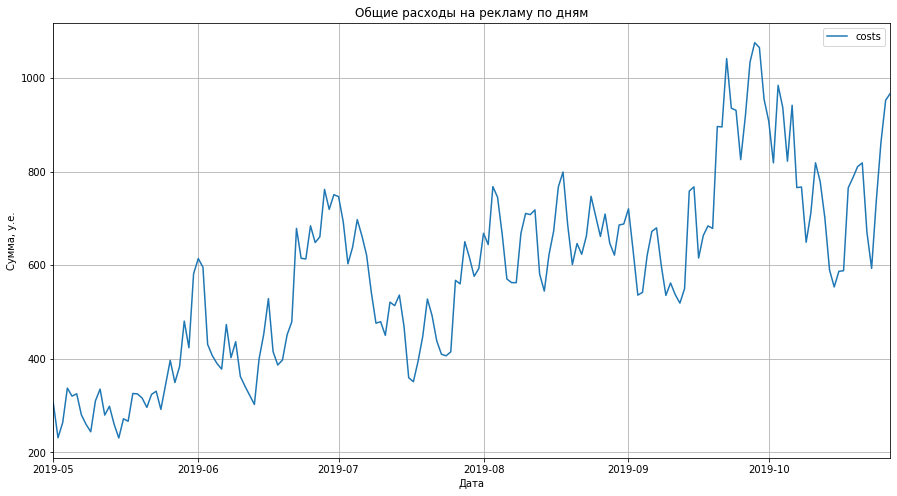

In [26]:
draw_graph('dt', 'costs', 'sum')
plt.title('Общие расходы на рекламу по дням')
plt.ylabel('Сумма, у.е.')
plt.xlabel('Дата')

Text(0.5, 0, 'Месяц')

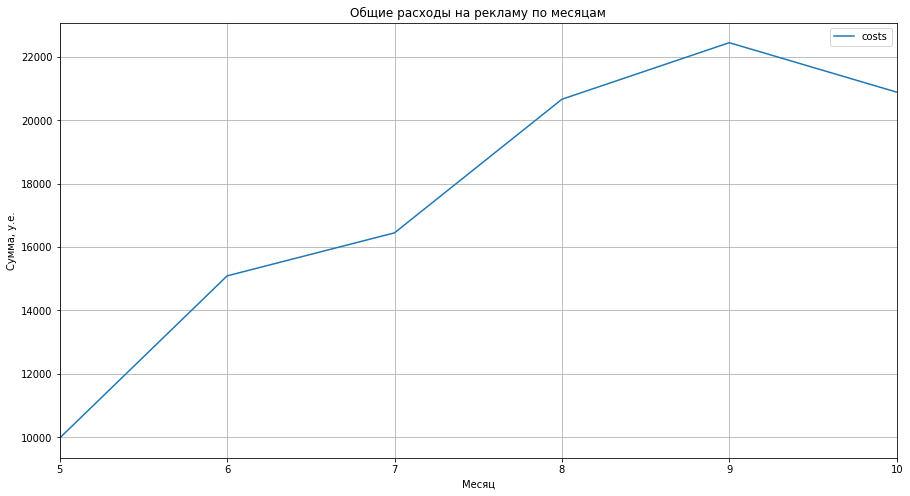

In [27]:
draw_graph('month', 'costs', 'sum')
plt.title('Общие расходы на рекламу по месяцам')
plt.ylabel('Сумма, у.е.')
plt.xlabel('Месяц')

Text(0.5, 0, 'Дата')

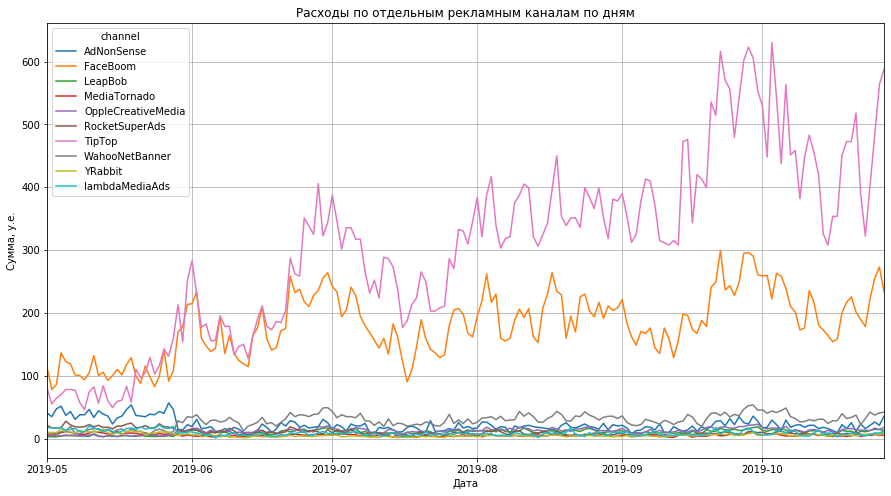

In [28]:
draw_graph('dt', 'costs', 'sum', columns = 'channel')
plt.title('Расходы по отдельным рекламным каналам по дням')
plt.ylabel('Сумма, у.е.')
plt.xlabel('Дата')

Text(0.5, 0, 'Месяц')

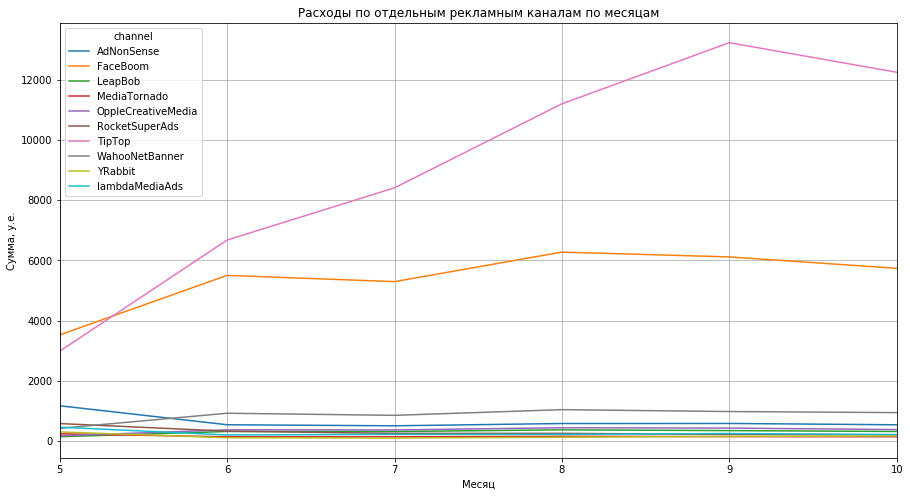

In [29]:
draw_graph('month', 'costs', 'sum', columns = 'channel')
plt.title('Расходы по отдельным рекламным каналам по месяцам')
plt.ylabel('Сумма, у.е.')
plt.xlabel('Месяц')

**Вывод**
- на рекламные каналы потрачено свыше 100 тыс у.е.
- от месяца к месяцу расходы планомерно росли и достигди пика в сентябре - в целом поскольку диапазон данных заканчивается 27 октябрем, то есть практически концом месяца, можно сказать что расходы в последний анализируемый месц незначительно снизились
- по каналам - у нас в лидерах TipTop c наибольшими расходами на рекламу, причем эти расходы также увеличиваются во времени, бюджет на покупку рекламы на FасеBoom не меняется с июня месяца и составляет 5,7 - 6,2 тыс в месяц, расходы на AdNonSense напротив снизились в июне. Остальные каналы составляют небольшую долю в бюджете и стоимость покупки рекламы данных источников трафика меняется в очень незначительных пределах

## Cредний CAC на одного пользователя для всего проекта и для каждого источника трафика

In [30]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [31]:
profiles['acquisition_cost'].mean()

0.7032778251826568

In [32]:
profiles.groupby('channel')[['acquisition_cost']].mean().sort_values(by = 'acquisition_cost', ascending = False).style.format({'acquisition_cost':'{:.2f}'})

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


**Вывод**
- средняя стоимость привлечения пользователя составила 0,7 у.е. 
- наиболее дорогой канал - TipTop c САС = 2.8 за привлеченного пользователя

# Оценка окупаемости рекламы

## Общая окупаемость рекламы - LTV, ROI, графики динамики LTV, CAC и ROI

Мы не будем включать органических пользователей, поскольку это сильно отразится на CAC в сторону его уменьшения и соответственно на ROI. Проанализируем все показатели только для пользователей, пришедших по рекламным каналам. Тем более мы даем оценку окупаемости рекламы

In [33]:
observation_date = datetime(2019, 11, 1).date()# момент анализа
horizon_days = 14# горизонт анализа 

In [34]:
profiles = profiles.query('channel != "organic"')

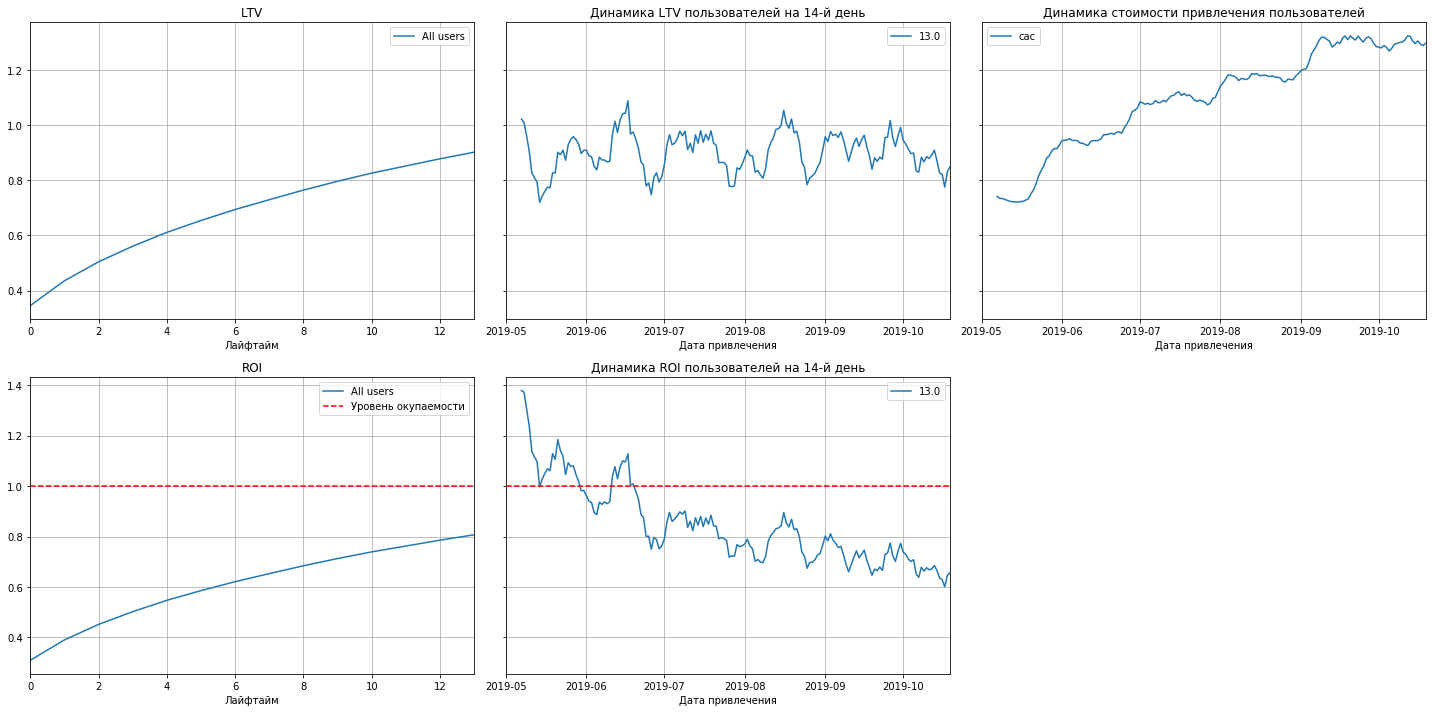

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Вывод**
- реклама не окупается. ROI закономерно растет при увеличении lifetime, но в конце второй недели достигает лишь 80%
- LTV также растет по мере увеличения lifetime и к концу второе недели составляет 0,9 
- в динамике LTV в принципе стабилен - наблюдабтся колебания 0,7-1,1, которые не говорят о значительномне ухудшении качества пользователей.
- расходы на привлечение пользователей увеличиваются 
- реклама окупалась лишь в мае и частично в июне - когда расходы на нее были минимальны.

Возможно, мы неправильно планируем рекламный бюджет и выбираем не те каналы для привлечения пользователей

## Окупаемость рекламы в зависимости от страны

Создадим функцию, учитывающую признаки клиента - страна, источник трацика

In [36]:
def plot_ltv_roi_by_dimensions(dimensions = []):

    ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

    plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


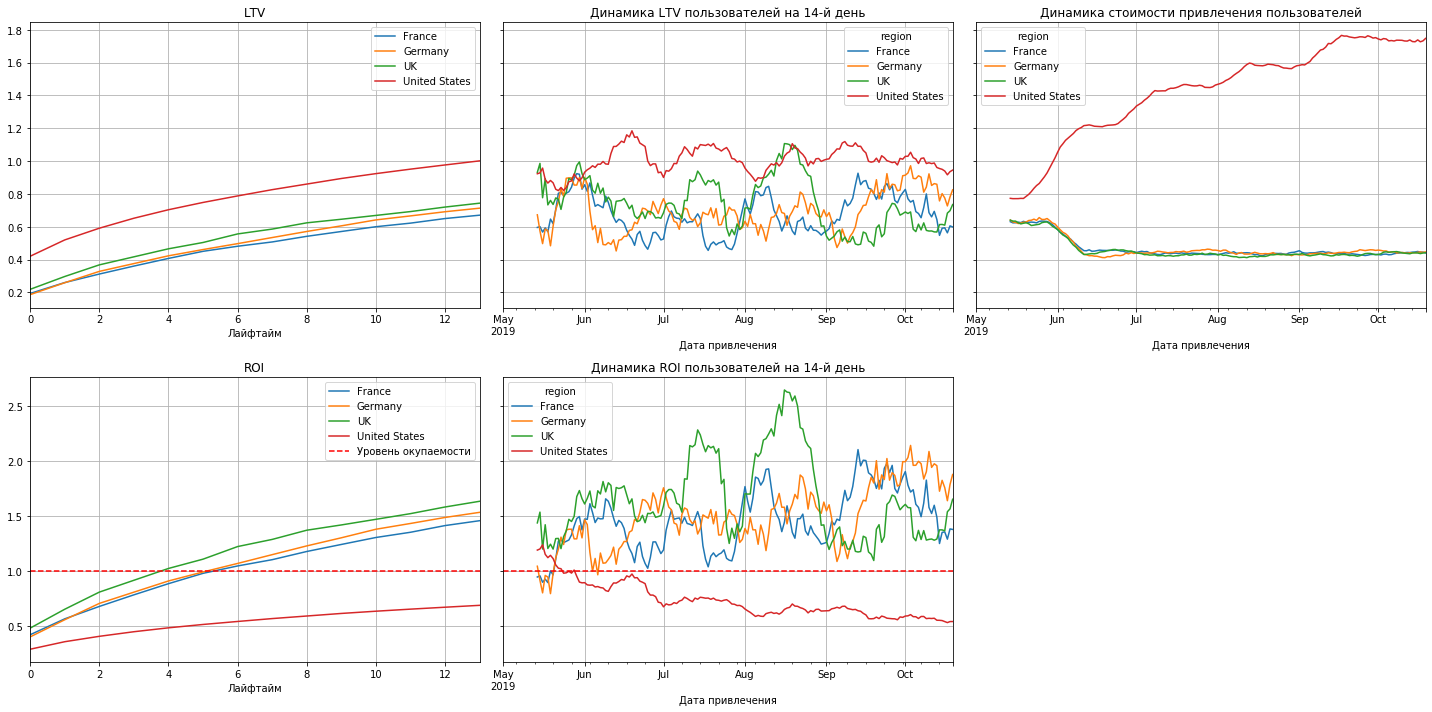

In [37]:
plot_ltv_roi_by_dimensions(dimensions = ['region'])

**Вывод**

**Для начала сосредоточимя на клиентах из США, как наибольшей группе пользователей с наибольшим числом плательщиков**
- пользователи США к концу lifetime имеют наиболее высокий LTV - 1. Клиенты из Франции, Германии и Великобритании мало чем отличаются в плане LTV - LTV 0.7
- в мае LTV американцев был самым низким, а в июне - самым высоким, скорее всего за счет начала покупки рекламы 
- привлечение пользователей из США обходится нам очень дорого - их CAC вырос более чем в два раза за 6 месяцев - обосновано ли было принято решение о разворачивание такой дорогостоящей рекламной деятельности?
- как результат высокого CAC для USA - пользователи из США не окупают рекламных расходов на их привлечение к концу lifetime. Более того показатель ROI снижается от месяца к месяцу - если в мае при минимальных расходах на рекламы американцы окупали эти расходы, то начиная с июня - ROI падает, и достигает минимального значения к концу анализиремого периода - всего 0,5. Интересно посмотреть при каком lifetime американцы стали бы себя окупать

**Для пользователей из других стран**
- несмотря на более низкий LTV по сравнению с США, пользователи Франции, Германии и Великобритании полностью окупают расходы на свое привлечение уже с 5 дня lifetime. В динамике ROI также показывает окупаемость клиентов за весь период - с мая по октябрь. Качество пользователей в некоторой степени подверженно сезонности - например более качественные пользователи наблюдались в Германии среди клиентов, первый раз воспользовавшихся приложением в июне или октябре, для UK - в августе. CAC - очень стабилен, помимо снижения в июле на 0,2


Судя по всему наша компания опрометчиво решила значительно увеличить рекламные расходы для привлечения пользователей США - эти пользователи приносят наибольший доход компании (количество, LTV, конверсия в платящих) Такая политика не принесла ожидаемых результатов - LTV американцев фактически оставался на том же уровне, то есть усиленная рекламная компания не повлияла на качество пользователей

При этом, не смотря на снижение рекламного бюджета в остальных странах, пользователи Германии, Франции и Великоблитании окупают расходы на их привлечение уже начиная с 5 дня lifetime.


## Окупаемость рекламы в зависимости от источника трафика

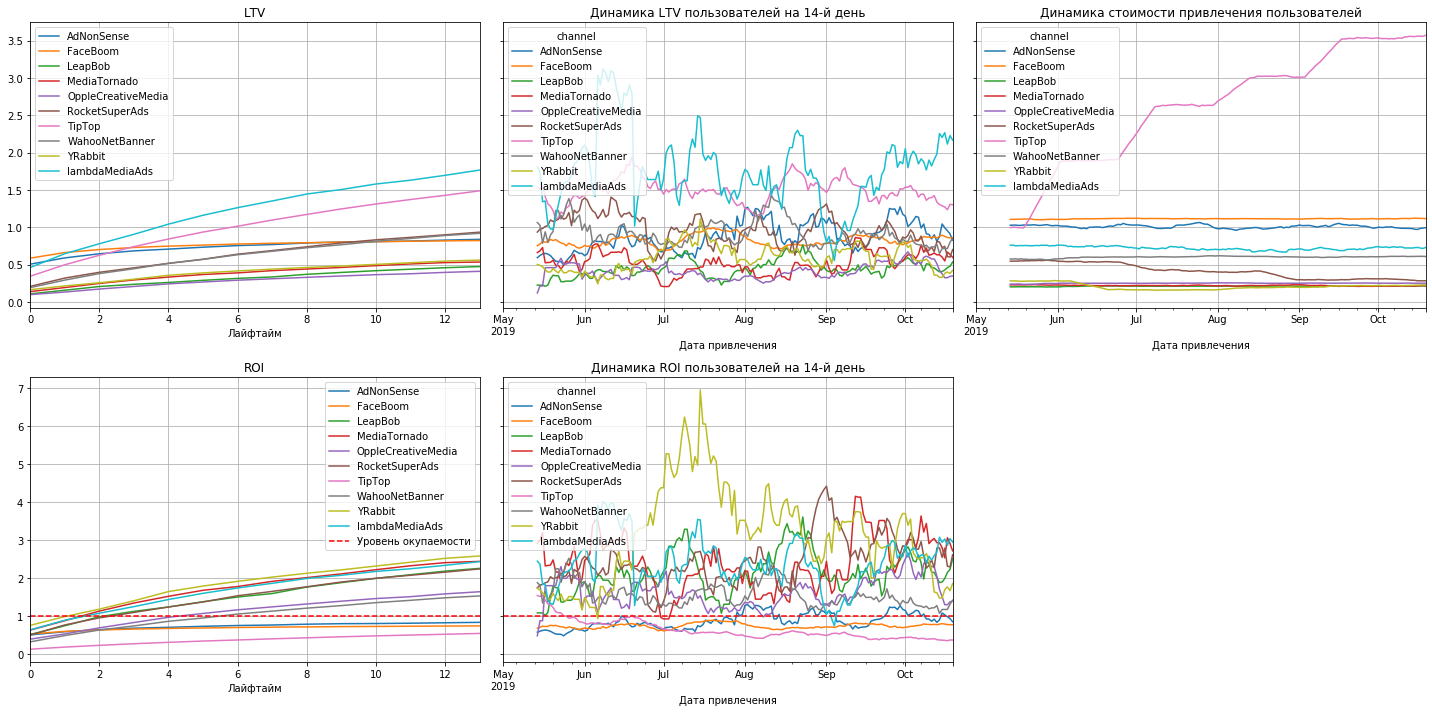

In [38]:
plot_ltv_roi_by_dimensions(dimensions = ['channel'])

**Вывод** 
- пользователи, пришедшие из AdNonSense, Faceboom, и особенно TipTop не окупают инвестиции на их привлечение, при этом Faceboom и TipTop - на протяжении всех 6 месяцев.
- мы видим, что наибольший LTV на конец второй недели - у клиентов из TipTop и lambdamediaads. Lambda явно лидирует по LTV пользователей все 6 месяцев, при этом ее CAC - гораздо ниже чем TipTop
- одним из лучших каналов по соотношению цена/качество пользоателей является YRabbit - особенно в июле, при незначительном снижении расходов на рекламу и повышении LTV фактически в два раза - для выяснения почему так сильно вырос LTV запросить дополнительную информацию - были ли скидки, промокоды или что-то подобное для клиентов пришедших с YRabbit

Прекратить вбухивать деньги в TipTop.

## Окупаемость рекламы в зависимости от девайса

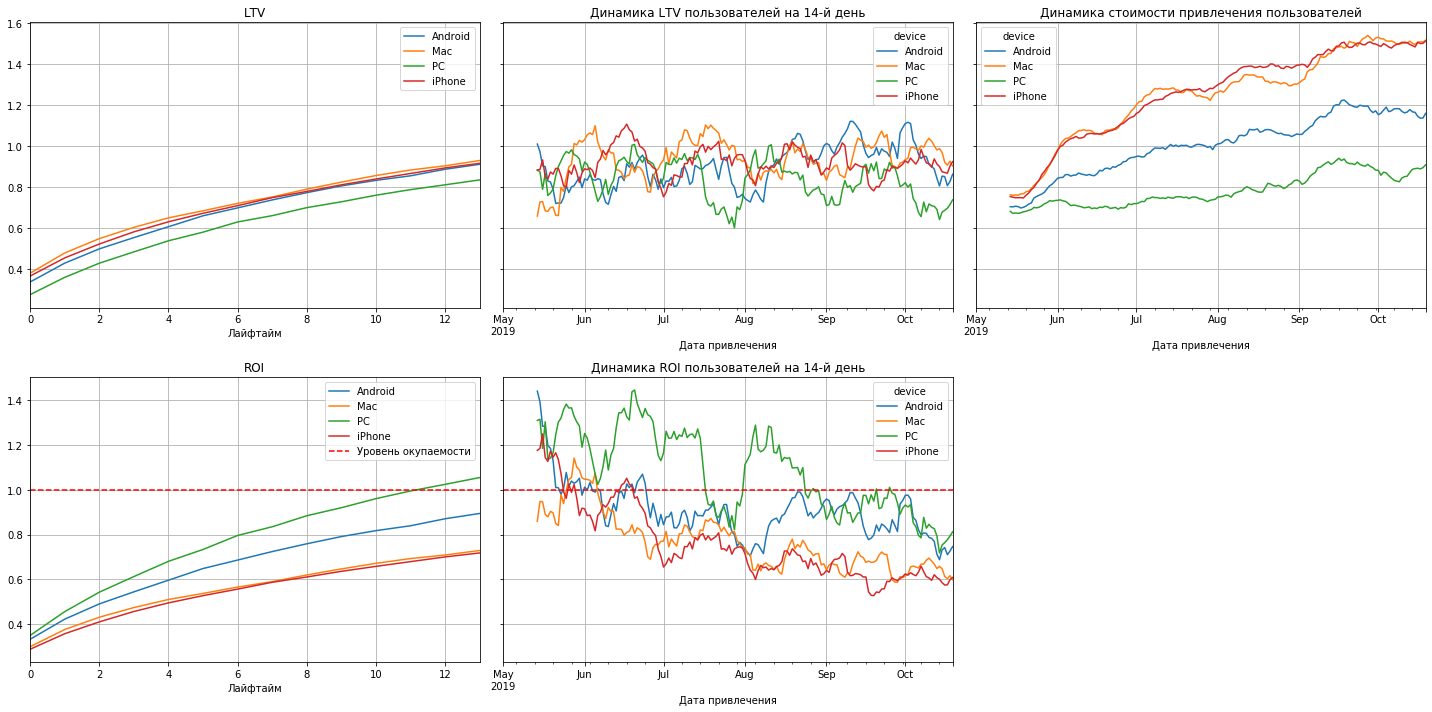

In [39]:
plot_ltv_roi_by_dimensions(dimensions = ['device'])

**Вывод**
- стоимость рекламы для iphone и macbook необосновано высока и увеличивается с каждым месяцем
- пользователи iphone, macbook и android не окупают затраты на их привлечение в течение практически всего рассматриваемого периода

## Конверсия и удержание с разбивкой по устройствам, странам, рекламным каналам

### Конверсия и удержание по странам

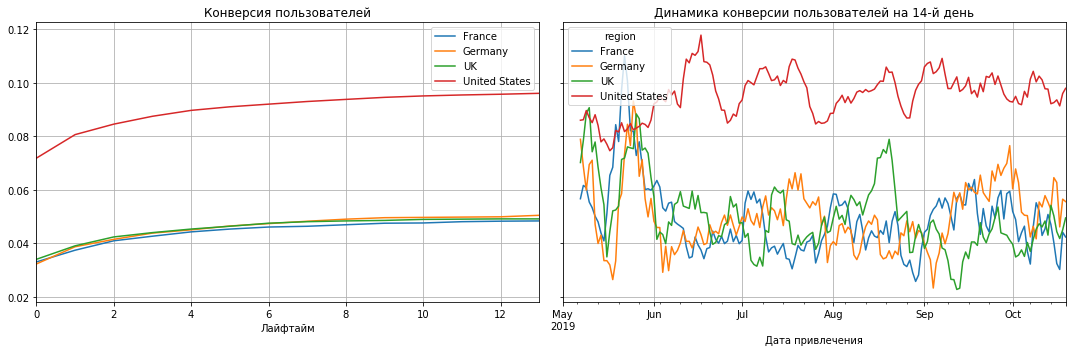

In [40]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


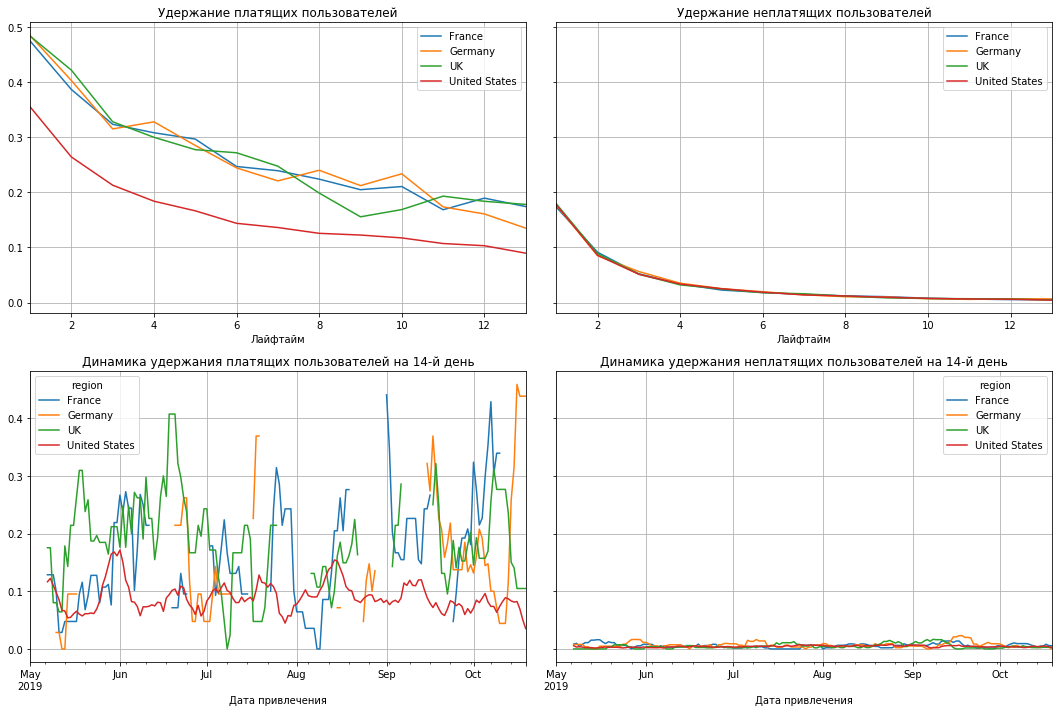

In [41]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод** 
- пользователи США достаточно хорошо конвертируются, причем стабильно все 6 месяцев
- остальные клиенты конвертируются хуже по сравнению с американцами
- при этом платящие американцы хуже всего удерживаются
- неплатящие пользователи удерживаются одинаково для всех стран - точнее неудерживаются одинаково -  к концу второй недели retention стремится к нулю - судя по-всему без платных фич наше приложение бесполезно и неинтересно


### Конверсия и удержание по устройствам

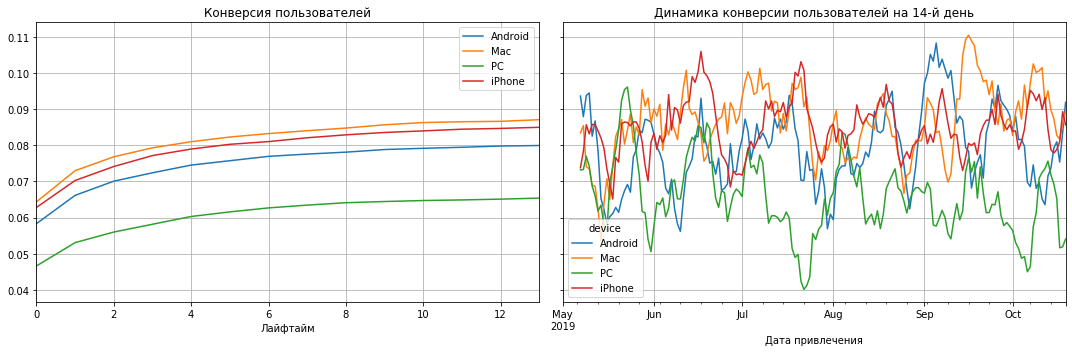

In [42]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


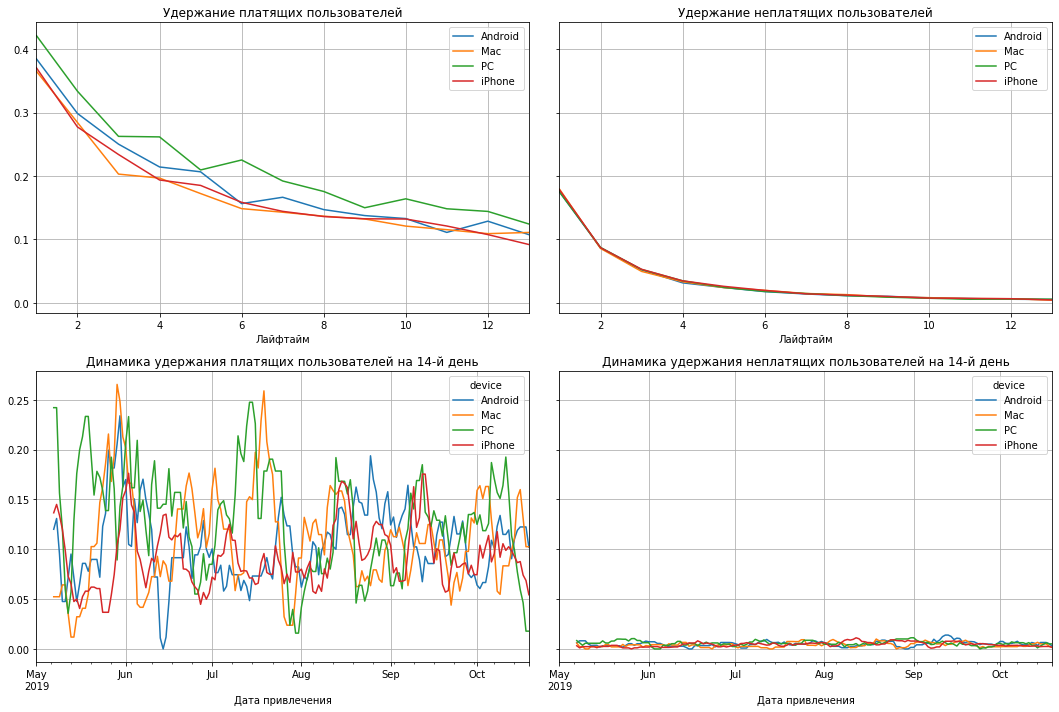

In [43]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**
- пользователи PC плохо конвертируется но хорошо удерживаются (платные)
- для остальных устройств каких-либо аномалий не обнаружено
- еще раз убеждаемся что к концу второй недели неплатящие пользователи фактически не удерживаются

### Конверсия и удержание по каналам

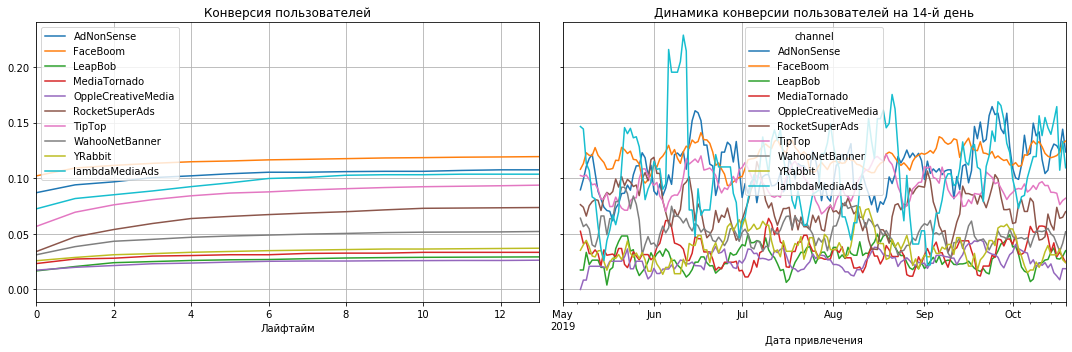

In [44]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


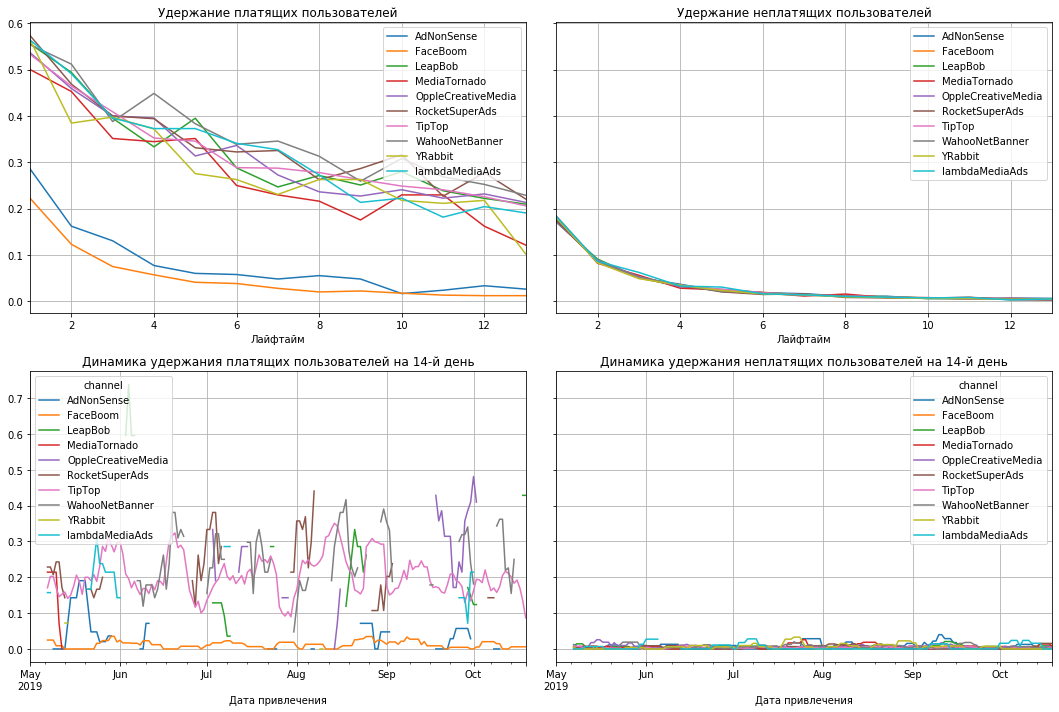

In [45]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**
- платящие пользователи с AdNonSense и FaceBoom стабильно очень плохо удерживаются. В остальном - без аномалий, за исключением неполноты данных, которую наглядно видно на графиках динамики удержания платящих пользователей

In [46]:
profiles.groupby(['region', 'channel'])['user_id'].count()

region         channel           
France         AdNonSense             1366
               LeapBob                2988
               OppleCreativeMedia     2991
               WahooNetBanner         2971
               lambdaMediaAds          742
Germany        AdNonSense             1219
               LeapBob                2519
               OppleCreativeMedia     2562
               WahooNetBanner         2579
               lambdaMediaAds          649
UK             AdNonSense             1295
               LeapBob                3046
               OppleCreativeMedia     3052
               WahooNetBanner         3003
               lambdaMediaAds          758
United States  FaceBoom              29144
               MediaTornado           4364
               RocketSuperAds         4448
               TipTop                19561
               YRabbit                4312
Name: user_id, dtype: int64

In [47]:
costs.query('channel =="TipTop"')['costs'].sum()/costs['costs'].sum()

0.5189829502745568

In [48]:
costs.query('channel =="FaceBoom"')['costs'].sum()/costs['costs'].sum()

0.3075491031524029

**Общий вывод**
- реклама не окупается. ROI закономерно растет при увеличении lifetime, но в конце второй недели достигает лишь 80%. Реклама окупалась лишь в мае и частично в июне - когда расходы на нее были минимальны.
- значительно снижают окупаемость рекламы - пользователи из CША, владельцы IPhone, клиенты привлеченные через TipTop, AdNonSense, Faceboom
- бОльшая часть рекламного бюджета тратиться на каналы для США TipTop и FaceBoom. В принципе тактика привлекать клиентов из CША логична, однако рекламные каналы выбраны неправильно - они дорогие (средний СAC TipTop например 2,8 - самое высокое значение среди всех) и не оказывают влияние на улучшение качества пользователей (увеличение LTV). Кроме того клиенты, пришедшие с FaceBoom, практически не удерживаются

# Выводы

**Причины неэффективности привлечения пользователей:**
- увеличение затрат на рекламу, таргитирующую пользователей из CША, но не улучшающую их качество и удержание. Это касается рекламных каналов TipTop и FaceBoom - дорогостоящих, неэффективных и не окупающих себя. Суммарный бюджет этих двух каналов составляет 80% от всего рекламного бюджета - 52% TipTop и 30% FaceBoom. Кроме того пользователи приходящие по FaceBoom практически не удерживаются

**Рекомендации**
- исключить TipTop и FaceBoom из рекламных каналов для привлечения клиентов из США - поиск альтернативных каналов либо дополнительное финансирование рекламный компаний в YRabbit, LambdaMediAds, RocketSuperAds. Пользователи из США по-прежнему остаются привлекательны в качестве источников прибыли (выше LTV  и CR по сравнению с европейцами)
- уделить особое внимание методам удержания пользователей - в частности американских, а также в целом владельцев IPhone и Mac - проверить соответствует ли качество платных услуг их ожиданиям, не происходит ли технических ошибок при использовании приложения на IPhone (проанализировать данные о сессиях, закончившихся ошибками)
- европейские пользователи хорошо удерживаются (возможно за счет того, что они в основном используют приложение в PC и Android), но плохо конвертируются, при этом они окупают рекламные расходы - попытаться увеличить конверсию за счет скидок, промокодов, бесплатного триала и т.п. Из рекламных каналов для европейских проверить  АdNonSense -  пользователи, приходящие по нему конвертируются, но абсолютно не удерживаются - возможно стоит пересмотреть содержание рекламы на этом канале - действительно ли наше приложение соответствует его рекламному описанию и оправдывает ожидания пользователей